In [140]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from scipy import stats

# Load and preprocess data
df = pd.read_parquet('/Users/ns/Downloads/combined_outcome_df.parquet')
# Calculate age
df['Age'] = (df['testDateTime'] - df['DOB']).dt.days / 365

# Time series preprocessing
time_series_columns = ['Time', 'Rf', 'VT', 'VE', 'VO2', 'VCO2', 'RQ', 'O2exp', 'CO2exp', 
                      'VE/VO2', 'VE/VCO2', 'VO2/Kg', 'METS', 'HR', 'VO2/HR', 'FeO2', 'FeCO2', 
                      'FetO2', 'FetCO2', 'FiO2', 'FiCO2', 'SpO2', 'Power', 'Real_Power', 
                      'Revolution', 'Speed', 'Grade', 'P_Syst', 'P_Diast', 'Phase', 'Ambient_Temp', 
                      'RH_Amb', 'Analyzer_Pressure', 'PB', 'Ti', 'Te', 'Dyspnea', 'Leg Pain']

def filter_time_series_columns(df, time_series_columns, skip_column, nan_threshold, empty_list_threshold):
    df_filtered = df.copy()
    for col in time_series_columns:
        if col == skip_column:
            continue
        df_filtered[col] = df_filtered[col].apply(
            lambda x: np.array([]) if pd.isna(x).mean() > nan_threshold else x
        )
        empty_array_count = df_filtered[col].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
        missing_array_proportion = empty_array_count / len(df_filtered[col])
        if missing_array_proportion > empty_list_threshold:
            df_filtered.drop(columns=[col], inplace=True)
    return df_filtered

df_filtered = filter_time_series_columns(df, time_series_columns, skip_column='Time', 
                                       nan_threshold=0.10, empty_list_threshold=0.10)

filtered_time_series_columns = [col for col in time_series_columns if col in df_filtered.columns 
                              and col != 'Phase']

def calculate_statistics_for_columns(df, time_series_columns, skip_column):
    stats_df = df.copy()
    stats_column_names = []
    for col in time_series_columns:
        if col == skip_column:
            continue
        stats_df[f"{col}_min"] = stats_df[col].apply(lambda x: np.nanmin(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_max"] = stats_df[col].apply(lambda x: np.nanmax(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_mean"] = stats_df[col].apply(lambda x: np.nanmean(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_std"] = stats_df[col].apply(lambda x: np.nanstd(x) if x.size != 0 else np.nan)
        stats_column_names.extend([f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_df.drop(columns=[col], inplace=True)
    return stats_df, stats_column_names

def calculate_statistics_for_columns_exercise_only(df, time_series_columns, skip_column):
    stats_df = df.copy()
    stats_column_names = []
    for col in time_series_columns:
        if col == skip_column:
            continue
            
        # Calculate statistics only during exercise phase
        stats_df[f"{col}_min"] = stats_df.apply(
            lambda row: np.nanmin(row[col][row['Time'] <= row['ExerciseDuration']]) 
            if isinstance(row[col], np.ndarray) and row[col].size != 0 and 
               np.any(row['Time'] <= row['ExerciseDuration']) else np.nan, axis=1)
        
        stats_df[f"{col}_max"] = stats_df.apply(
            lambda row: np.nanmax(row[col][row['Time'] <= row['ExerciseDuration']])
            if isinstance(row[col], np.ndarray) and row[col].size != 0 and 
               np.any(row['Time'] <= row['ExerciseDuration']) else np.nan, axis=1)
        
        stats_df[f"{col}_mean"] = stats_df.apply(
            lambda row: np.nanmean(row[col][row['Time'] <= row['ExerciseDuration']])
            if isinstance(row[col], np.ndarray) and row[col].size != 0 and 
               np.any(row['Time'] <= row['ExerciseDuration']) else np.nan, axis=1)
        
        stats_df[f"{col}_std"] = stats_df.apply(
            lambda row: np.nanstd(row[col][row['Time'] <= row['ExerciseDuration']])
            if isinstance(row[col], np.ndarray) and row[col].size != 0 and 
               np.any(row['Time'] <= row['ExerciseDuration']) else np.nan, axis=1)
            
        stats_column_names.extend([f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_df.drop(columns=[col], inplace=True)
    return stats_df, stats_column_names

stats_df, stats_column_names = calculate_statistics_for_columns(df_filtered, filtered_time_series_columns, 
                                                              skip_column='Time')

# Prepare features and target
feature_columns = stats_column_names + ['Gender', 'Age', 'Height', 'Weight', 'TestDuration', 
                                      'ExerciseDuration', 'BarometricPress', 'AmbientTemp', 'AmbientRH']
data = stats_df[['Death', 'composite_outcome'] + feature_columns] #.dropna(axis=0, how='any')
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['BarometricPress'] = data.BarometricPress.astype(int)

# Split features and target
features = data[feature_columns]
outcome = data['Death']  # or data['Death'] for death prediction

# Perform 100 random train-test splits and calculate AUC for each
n_iterations = 50
auc_scores = []

for i in range(n_iterations):
    # Train test split with different random state each time
    x_train, x_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, 
                                                       random_state=i, shuffle=True, 
                                                       stratify=outcome)
    
    # Train model
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i, max_depth=3, learning_rate=0.1)
    model.fit(x_train, y_train)
    
    # Calculate ROC AUC
    y_prob = model.predict_proba(x_test)[:,1]
    auc_scores.append(roc_auc_score(y_test, y_prob))

# Calculate mean and 95% CI
mean_auc = np.mean(auc_scores)
ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean_auc, scale=stats.sem(auc_scores))

print(f'Mean ROC AUC Score: {mean_auc:.4f}')
print(f'95% CI: ({ci_lower:.4f}, {ci_upper:.4f})')

Mean ROC AUC Score: 0.8348
95% CI: (0.8256, 0.8441)


In [ ]:
df["yr"]

In [143]:
# Calculate days between Feb 1 2023 and each test date
# Allow option to use either Death or composite_outcome
outcome_type = "Death" # or "Death" or "composite_outcome"

reference_date = pd.to_datetime('2023-02-01')
years_to_censored = (reference_date - pd.to_datetime(stats_df["testDate"])).dt.days/365

if outcome_type == "Death":
    time_to_event = np.where(pd.isna(stats_df["death_yrs"]), years_to_censored, stats_df["death_yrs"])
    y_event = stats_df["Death"]
elif outcome_type == "composite_outcome":
    time_to_event = np.where(pd.isna(stats_df["composite_outcome_yrs"]), years_to_censored, stats_df["composite_outcome_yrs"]) 
    y_event = stats_df["composite_outcome"]
else:
    raise ValueError(f"Invalid outcome type: {outcome_type}. Please choose 'Death' or 'composite_outcome'.")

# Perform 100 random train-test splits and calculate C-index for each
n_iterations = 100
c_index_scores = []

for i in range(n_iterations):
    # Train test split with different random state each time
    x_train, x_test, y_train_event, y_test_event, y_train_time, y_test_time = train_test_split(
        features, y_event, time_to_event, test_size=0.3, stratify=y_event, random_state=i
    )

    # Create DMatrix objects with survival labels
    dtrain = xgb.DMatrix(x_train)
    dtest = xgb.DMatrix(x_test)

    # Set survival labels
    dtrain.set_float_info('label', y_train_time)
    dtrain.set_float_info('weight', y_train_event)
    dtest.set_float_info('label', y_test_time)
    dtest.set_float_info('weight', y_test_event)

    # Set parameters
    params = {
        'objective': 'survival:cox',
        'eval_metric': ['cox-nloglik'],
        'max_depth': 3,
        'learning_rate': 0.01,
        'tree_method': 'hist'
    }

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    # Get risk scores and calculate C-index
    test_risk_scores = model.predict(dtest)
    c_index = concordance_index(y_test_time, -test_risk_scores, y_test_event)
    c_index_scores.append(c_index)

# Calculate mean and 95% CI
mean_c_index = np.mean(c_index_scores)
ci_lower, ci_upper = stats.norm.interval(0.95, loc=mean_c_index, scale=stats.sem(c_index_scores))

print(f'Mean C-index: {mean_c_index:.4f}')
print(f'95% CI: ({ci_lower:.4f}, {ci_upper:.4f})')

# Get feature importance from final model
importance = model.get_score(importance_type='gain')
importance = pd.Series(importance).sort_values(ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

Mean C-index: 0.6047
95% CI: (0.5817, 0.6277)

Top 10 most important features:
VE/VO2_max                108.621567
RQ_mean                   107.209534
Analyzer_Pressure_mean     92.432404
Age                        77.332199
VE/VO2_std                 76.545334
CO2exp_min                 73.403275
Ti_max                     56.558197
RQ_std                     42.394276
TestDuration               41.110672
VE_max                     37.854652
dtype: float64


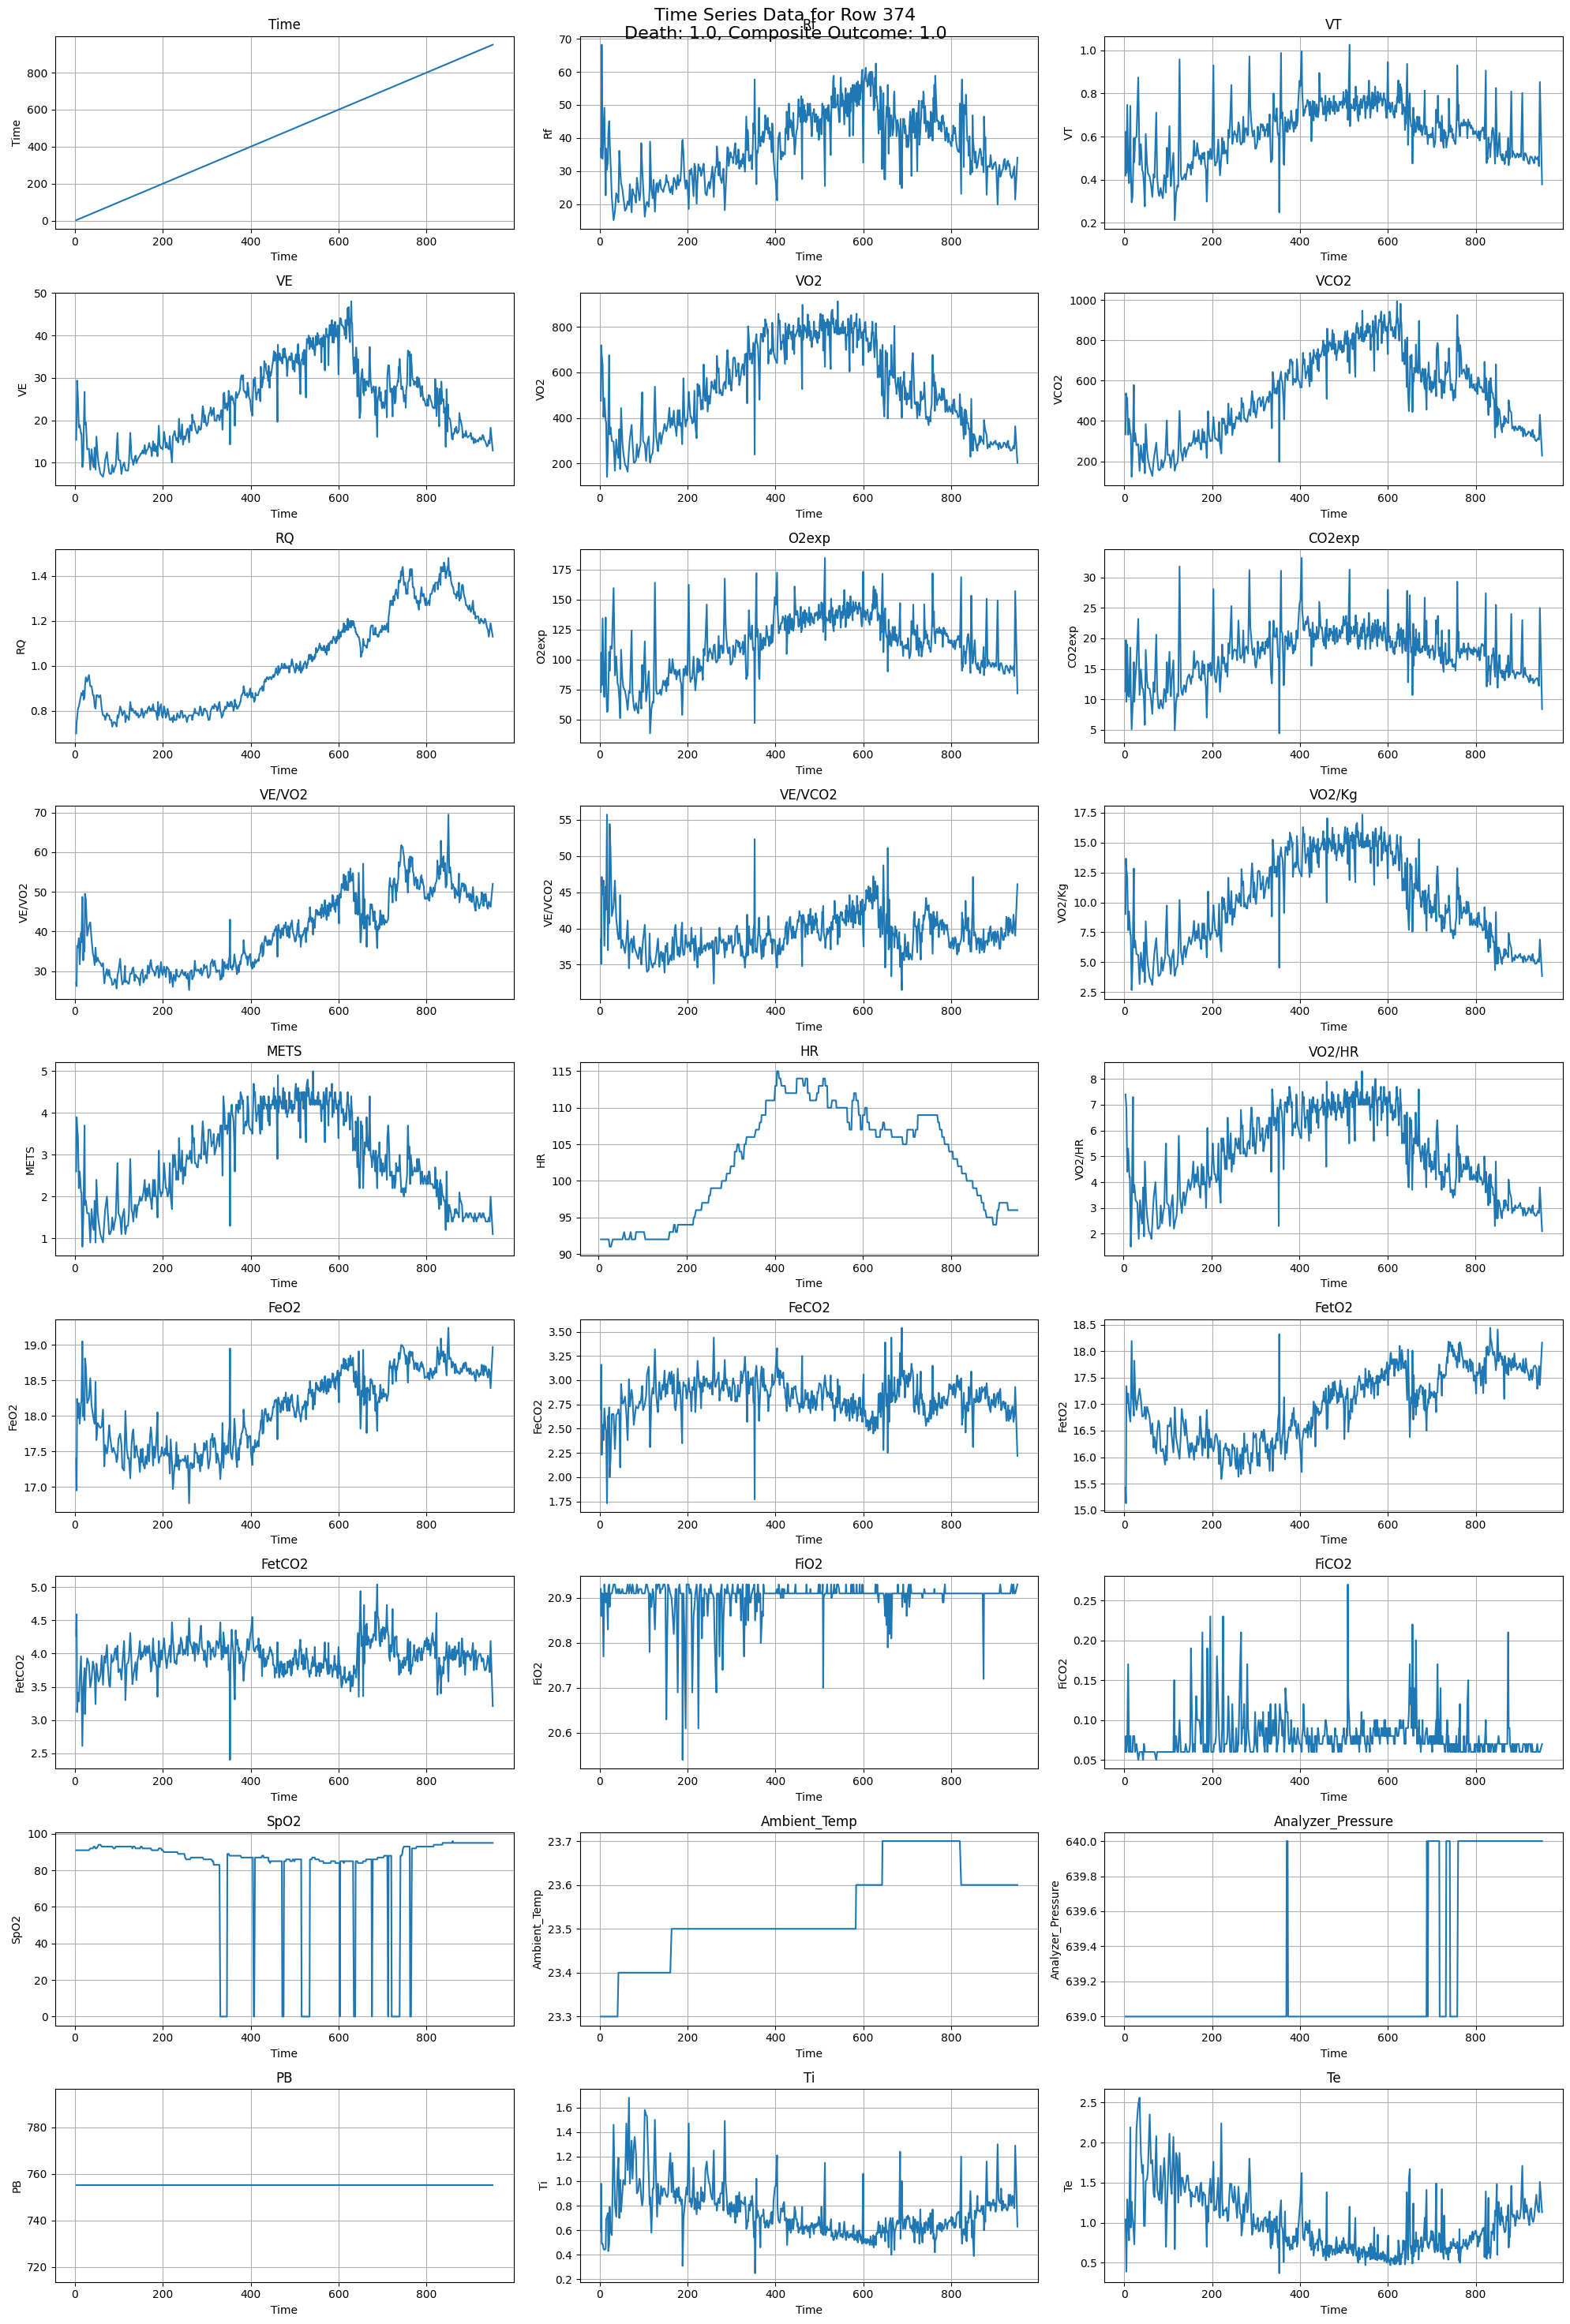

In [85]:
# Import matplotlib
import matplotlib.pyplot as plt

def plot_time_series_for_row(df, row_idx, time_series_columns, figsize=(20, 30)):
    """
    Plot all available time series data for a specific row in the dataframe
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe containing the time series data
    row_idx : int
        The index of the row to plot
    time_series_columns : list
        List of column names containing time series data
    figsize : tuple
        Figure size (width, height)
    """
    # Get the row data
    row_data = df.iloc[row_idx]
    
    # Filter out columns where the data is empty
    valid_columns = [col for col in time_series_columns 
                    if isinstance(row_data[col], np.ndarray) 
                    and row_data[col].size > 0]
    
    # Calculate number of rows and columns for subplots
    n_plots = len(valid_columns)
    n_cols = 3  # You can adjust this
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(f'Time Series Data for Row {row_idx}\n'
                 f'Death: {row_data["Death"]}, Composite Outcome: {row_data["composite_outcome"]}',
                 fontsize=16)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Plot each time series
    for idx, col in enumerate(valid_columns):
        time_data = row_data['Time']
        series_data = row_data[col]
        
        axes[idx].plot(time_data, series_data)
        axes[idx].set_title(col)
        axes[idx].set_xlabel('Time')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True)
    
    # Turn off any unused subplots
    for idx in range(len(valid_columns), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Example usage - plot time series for the first row
plot_time_series_for_row(df, 374, filtered_time_series_columns)

In [84]:
# Find the iloc position of row with index 931
iloc_pos = df.index.get_loc(1943)
print(f"Row with index 931 is at position (iloc): {iloc_pos}")

Row with index 931 is at position (iloc): 374


In [81]:
df[df.Death == 1].head(20)

,ID1,testDate,testTime,testDateTime,MRN,DOB,Height,AmbientTemp,Weight,TestDuration,...,post_valve_surgery_unspecified_yrs,post_ventricular_fib_flut,post_ventricular_fib_flut_date,post_ventricular_fib_flut_yrs,post_ventricular_tachycardia,post_ventricular_tachycardia_date,post_ventricular_tachycardia_yrs,composite_outcome,composite_outcome_yrs,Age
931,MRN-00804443,2014-09-29,8:41 AM,2014-09-29 08:41:00-07:00,804443.0,1958-03-07 00:00:00-08:00,175.3,20.0,104.30,480.0,...,NaN,0.0,NaT,NaN,1.0,2015-04-13,0.54,0.0,NaN,56.602740
2990,MRN-01213735,2014-12-29,1:37 PM,2014-12-29 13:37:00-08:00,1213735.0,1956-11-12 00:00:00-08:00,160.0,22.0,91.60,440.0,...,NaN,1.0,2015-02-04,0.10,1.0,2015-02-04,0.10,1.0,0.10,58.167123
176,MRN-06271597,2016-09-20,2:20 PM,2016-09-20 14:20:00-07:00,6271597.0,1956-12-05 00:00:00-08:00,165.1,24.0,72.12,703.0,...,0.43,0.0,NaT,NaN,0.0,NaT,NaN,1.0,0.49,59.832877
3181,MRN-06295604,2016-12-06,3:35 PM,2016-12-06 15:35:00-08:00,6295604.0,1965-11-11 00:00:00-08:00,167.6,25.0,70.31,880.0,...,2.84,0.0,NaT,NaN,1.0,2017-05-24,0.46,1.0,2.84,51.104110
2206,MRN-08230088,2018-01-30,1:41 PM,2018-01-30 13:41:00-08:00,8230088.0,1984-06-14 00:00:00-07:00,170.2,24.0,127.46,341.0,...,0.23,1.0,2018-03-20,0.13,0.0,NaT,NaN,1.0,0.13,33.652055
2869,MRN-08498263,2017-02-01,10:51 AM,2017-02-01 10:51:00-08:00,8498263.0,1961-04-09 00:00:00-08:00,177.8,24.0,93.44,972.0,...,NaN,0.0,NaT,NaN,1.0,2017-09-05,0.59,1.0,0.59,55.854795
1515,MRN-12592606,2014-08-29,3:10 PM,2014-08-29 15:10:00-07:00,12592606.0,1943-10-17 00:00:00-07:00,149.9,22.0,95.30,498.0,...,NaN,0.0,NaT,NaN,0.0,NaT,NaN,0.0,NaN,70.915068
752,MRN-14633432,2019-04-25,8:57 AM,2019-04-25 08:57:00-07:00,14633432.0,1955-06-25 00:00:00-07:00,165.1,21.0,72.57,1313.0,...,NaN,1.0,2020-02-01,0.77,1.0,2020-01-30,0.77,1.0,0.77,63.876712
330,MRN-14636047,2018-02-22,3:47 PM,2018-02-22 15:47:00-08:00,14636047.0,1956-08-09 00:00:00-07:00,152.4,25.0,78.93,1050.0,...,NaN,1.0,2019-11-16,1.73,1.0,2019-11-16,1.73,1.0,1.73,61.580822
2700,MRN-14642615,2014-08-26,8:44 AM,2014-08-26 08:44:00-07:00,14642615.0,1941-06-30 00:00:00-08:00,165.1,20.0,70.80,493.0,...,NaN,0.0,NaT,NaN,1.0,2014-08-27,0.00,0.0,NaN,73.205479


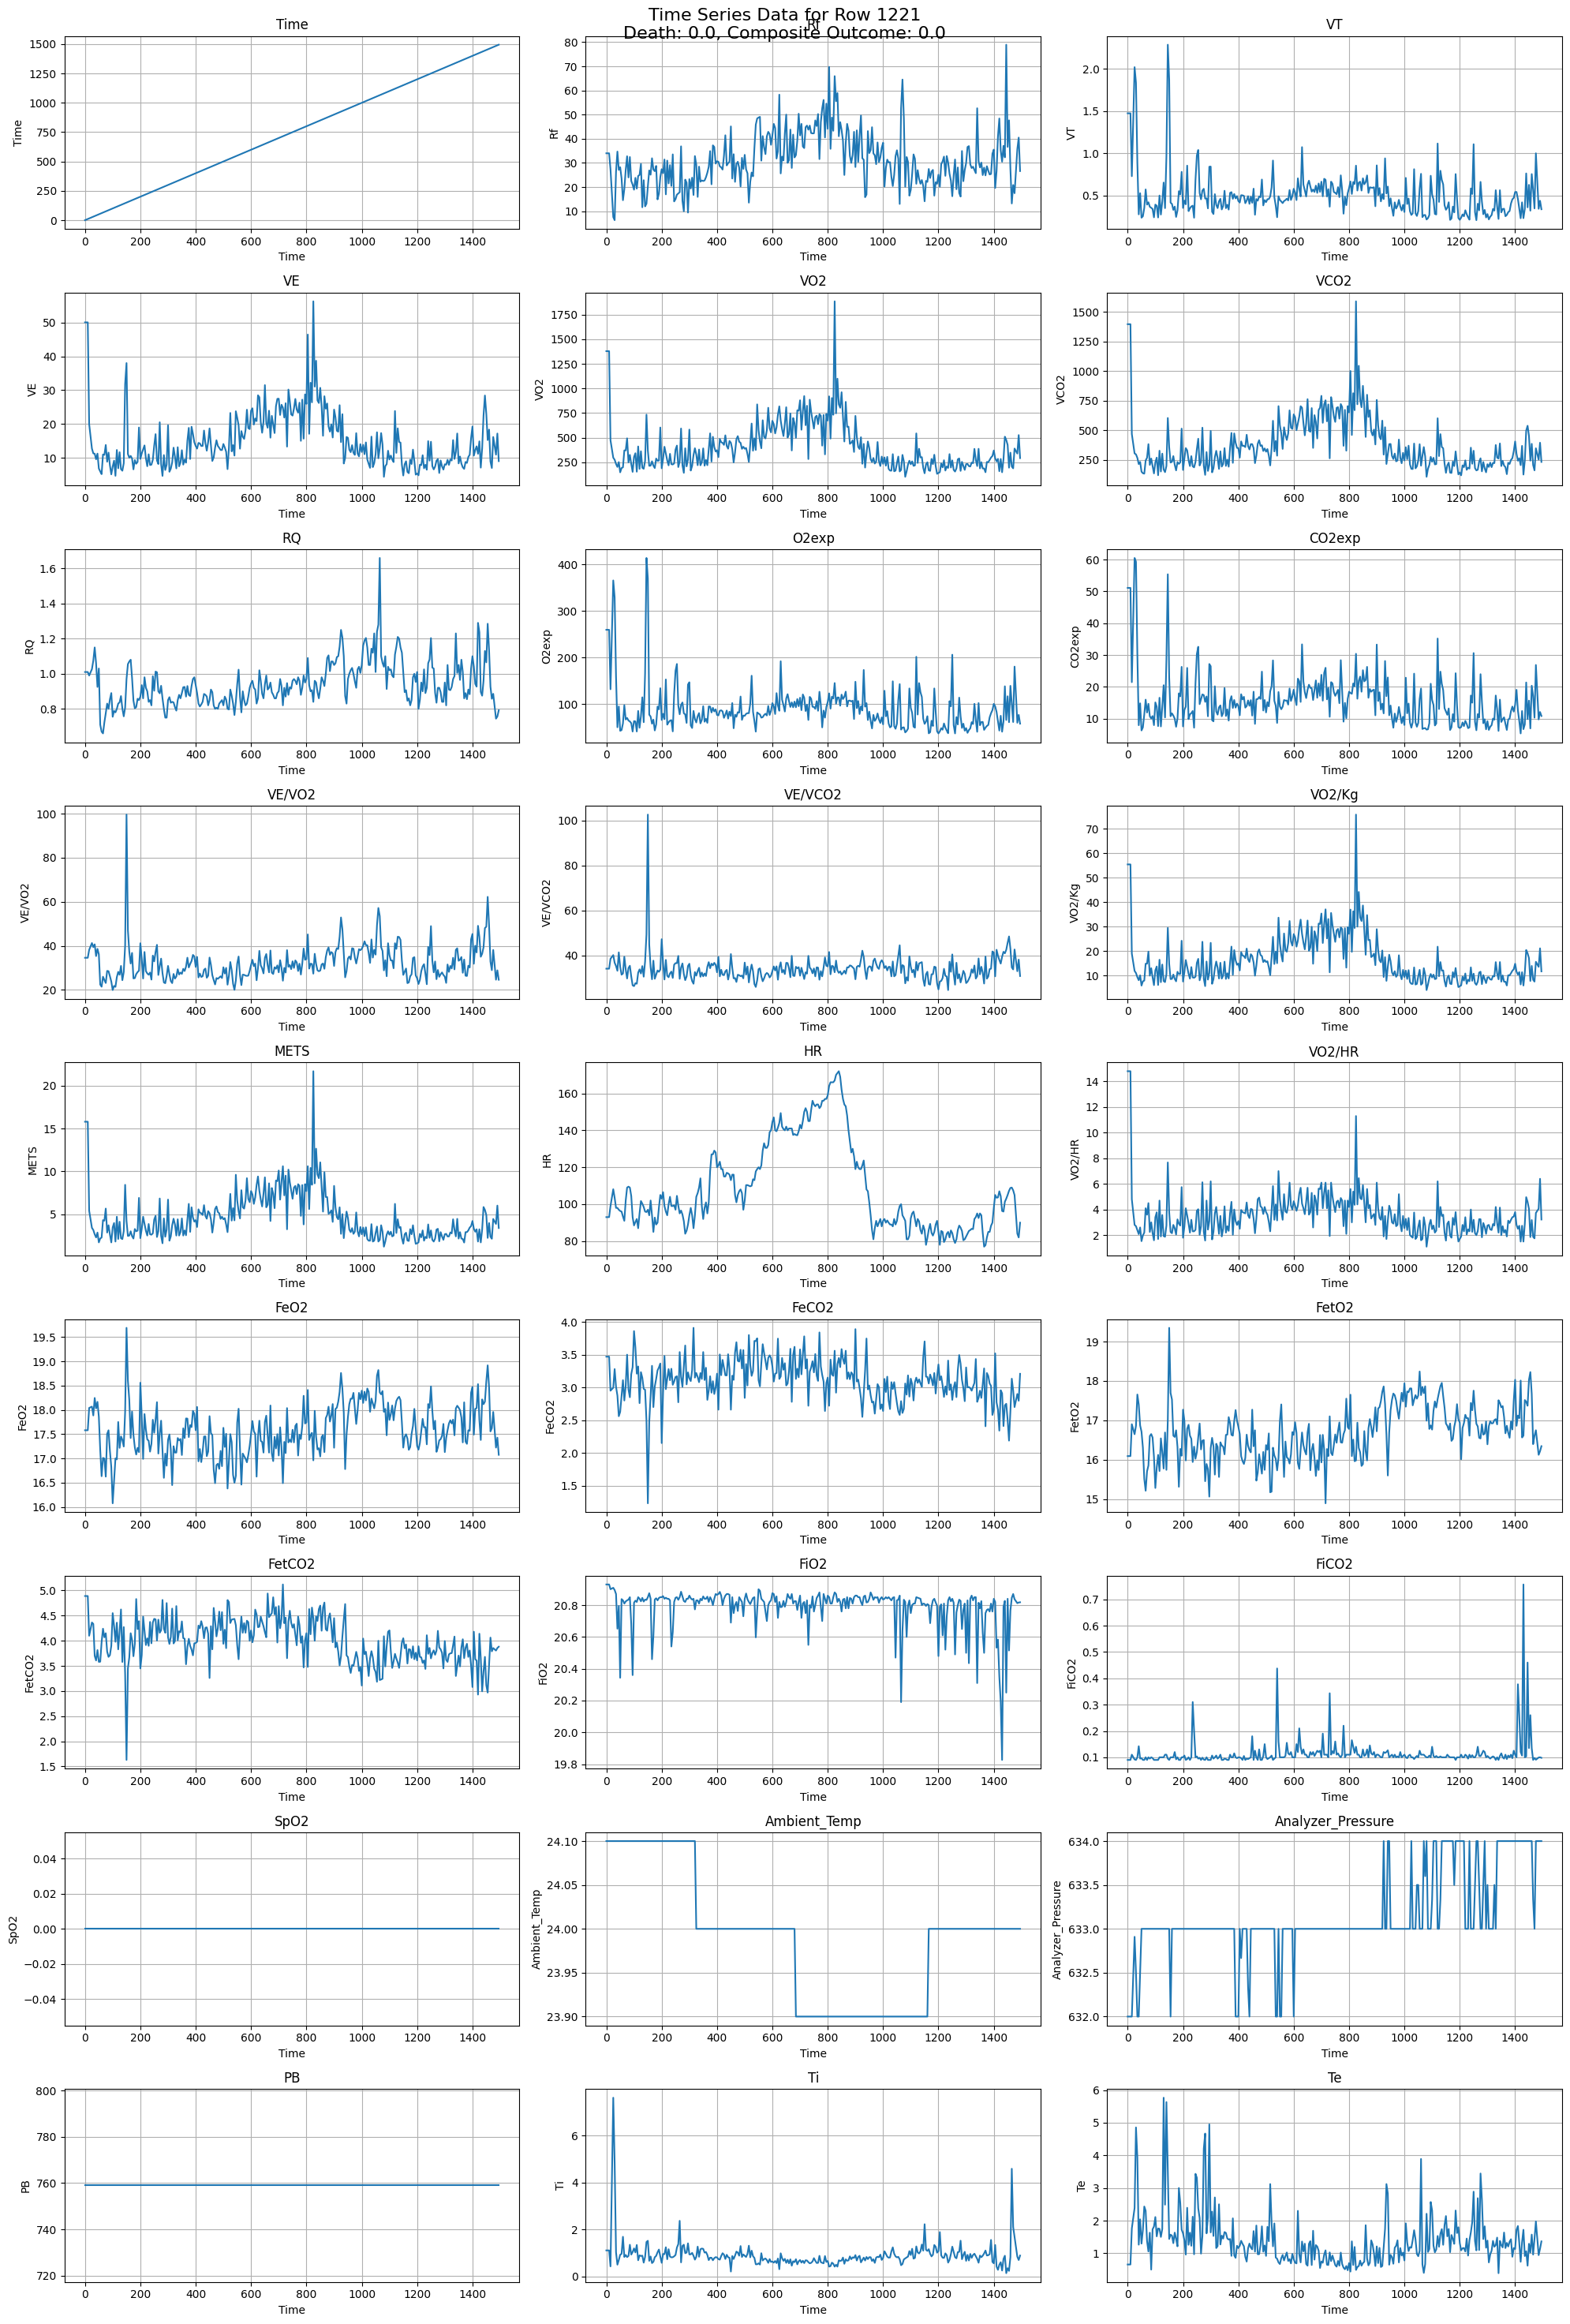


Time differences between consecutive points:
Mean: 5.00 seconds
Std: 0.00 seconds


In [23]:
def interpolate_time_series(df, time_series_columns, interval=5):
    """
    Interpolate time series data to have regular intervals
    
    Parameters:
    -----------
    df : pandas DataFrame
        The original dataframe containing the time series data
    time_series_columns : list
        List of column names containing time series data
    interval : int
        Desired time interval in seconds (default: 5)
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with interpolated time series data
    """
    df_interp = df.copy()
    
    for idx in df_interp.index:
        row = df_interp.loc[idx]
        time_data = row['Time']
        
        # Skip if no time data
        if not isinstance(time_data, np.ndarray) or time_data.size == 0:
            continue
            
        # Create regular time points from 0 to max time, every 'interval' seconds
        new_time = np.arange(0, time_data[-1], interval)
        
        # Interpolate each time series
        for col in time_series_columns:
            if col == 'Time':
                continue
                
            series_data = row[col]
            # Skip if empty data
            if not isinstance(series_data, np.ndarray) or series_data.size == 0:
                continue
                
            # Interpolate using numpy
            try:
                interpolated = np.interp(new_time, time_data, series_data)
                df_interp.at[idx, col] = interpolated
                df_interp.at[idx, 'Time'] = new_time
            except ValueError as e:
                print(f"Error interpolating {col} for row {idx}: {e}")
                continue
    
    return df_interp

# Interpolate the data
df_interpolated = interpolate_time_series(df, filtered_time_series_columns)

# After the interpolation code, add:
def create_time_series_matrix(df_row, time_series_columns):
    """
    Convert time series data for a single row into a matrix format
    """
    # Skip 'Time' and any empty columns
    valid_columns = [col for col in time_series_columns 
                    if col != 'Time' 
                    and isinstance(df_row[col], np.ndarray) 
                    and df_row[col].size > 0]
    
    # Create matrix where each column is a different measurement
    matrix = np.vstack([df_row[col] for col in valid_columns]).T
    
    return matrix, valid_columns


# You can verify the interpolation worked by plotting a row
plot_time_series_for_row(df_interpolated, 1221, filtered_time_series_columns)

# Optional: Print the time differences to verify 5-second intervals
row = df_interpolated.iloc[1221]
time_diffs = np.diff(row['Time'])
print("\nTime differences between consecutive points:")
print(f"Mean: {np.mean(time_diffs):.2f} seconds")
print(f"Std: {np.std(time_diffs):.2f} seconds")

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_interpolated.iloc[1222].to_string())
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns') 
pd.reset_option('display.width')

ID1                                                                                MRN-34268375
testDate                                                                    2019-05-01 00:00:00
testTime                                                                                8:19 AM
testDateTime                                                          2019-05-01 08:19:00-07:00
MRN                                                                                 3.42684e+07
DOB                                                                   1943-11-21 00:00:00-07:00
Height                                                                                    182.9
AmbientTemp                                                                                  22
Weight                                                                                    78.93
TestDuration                                                                               1313
AmbientRH                               

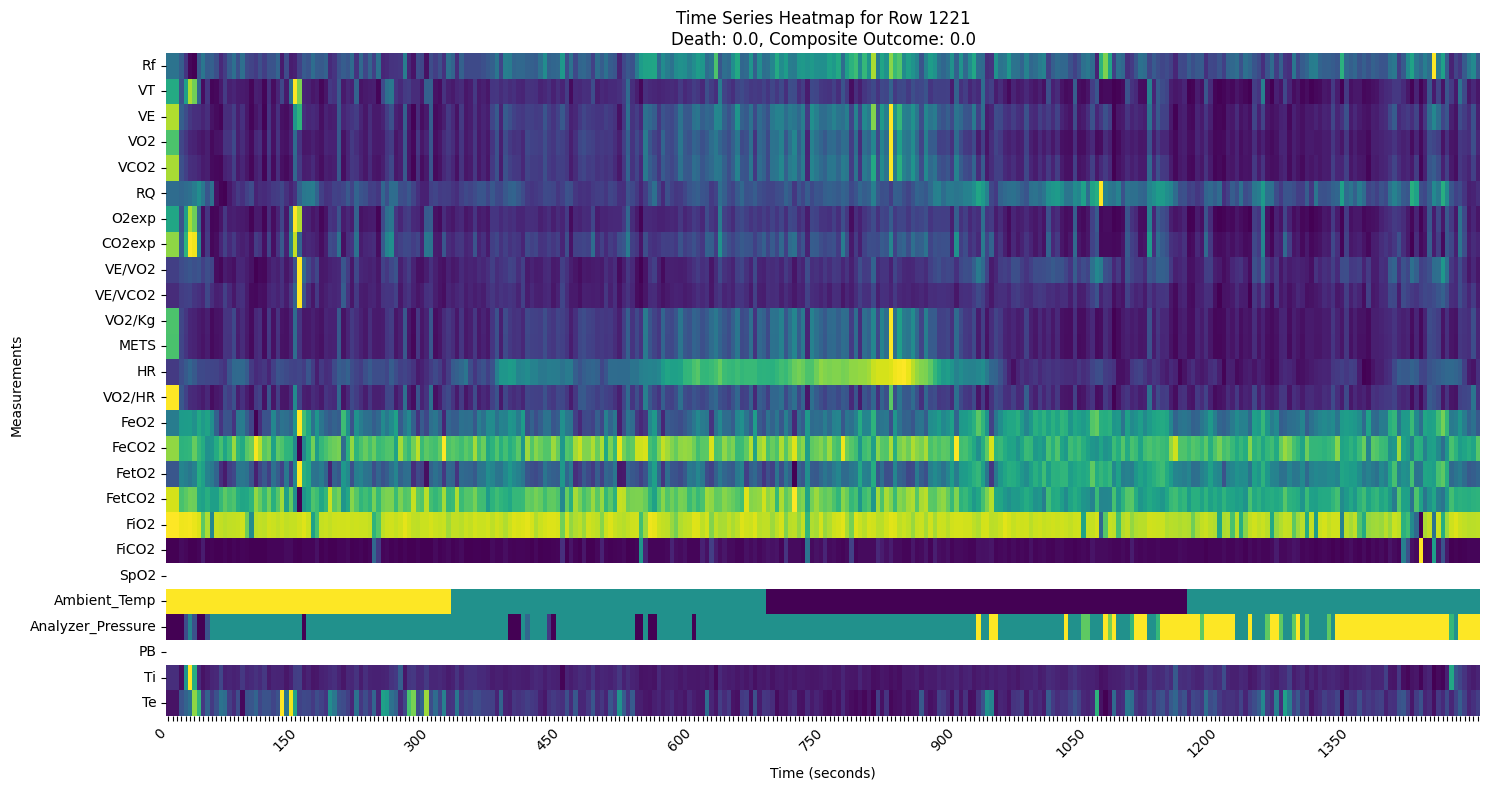

In [22]:
def plot_time_series_heatmap(df, row_idx, time_series_columns, figsize=(15, 8), 
                            show_labels=True, show_colorbar=True, filepath=None):
    """
    Create a heatmap visualization of the time series data with measurements on y-axis
    and time on x-axis
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing the time series data
    row_idx : int
        Index of the row to plot
    time_series_columns : list
        List of column names containing time series data
    figsize : tuple
        Figure size (width, height)
    show_labels : bool
        Whether to show axis labels, ticks, and title
    show_colorbar : bool
        Whether to show the colorbar
    filepath : str or None
        If provided, saves the figure to this path
    """
    row_data = df.iloc[row_idx]
    matrix, valid_columns = create_time_series_matrix(row_data, time_series_columns)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Normalize each column to [0,1] range for better visualization
    matrix_normalized = (matrix - matrix.min(axis=0)) / (matrix.max(axis=0) - matrix.min(axis=0))
    
    # Create time labels
    time_points = row_data['Time']
    step = len(time_points) // 10
    time_labels = [f'{t:.0f}' if i % step == 0 else '' for i, t in enumerate(time_points)]
    
    # Create heatmap with transposed matrix
    sns.heatmap(matrix_normalized.T,
                xticklabels=time_labels if show_labels else False,
                yticklabels=valid_columns if show_labels else False,
                cmap='viridis',
                cbar=show_colorbar)
    
    if show_labels:
        plt.title(f'Time Series Heatmap for Row {row_idx}\n'
                  f'Death: {row_data["Death"]}, Composite Outcome: {row_data["composite_outcome"]}')
        plt.ylabel('Measurements')
        plt.xlabel('Time (seconds)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    else:
        plt.xticks([])
        plt.yticks([])
        plt.title('')
        # Remove all margins and spacing
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    # Save the figure if filepath is provided
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0 if not show_labels else None, dpi=300)
    
    plt.show()
    plt.close()

# Example usage without labels and saving to file
plot_time_series_heatmap(df_interpolated, 1221, filtered_time_series_columns, 
                        show_labels=True, show_colorbar=False,
                        filepath='heatmap_no_labels.png')

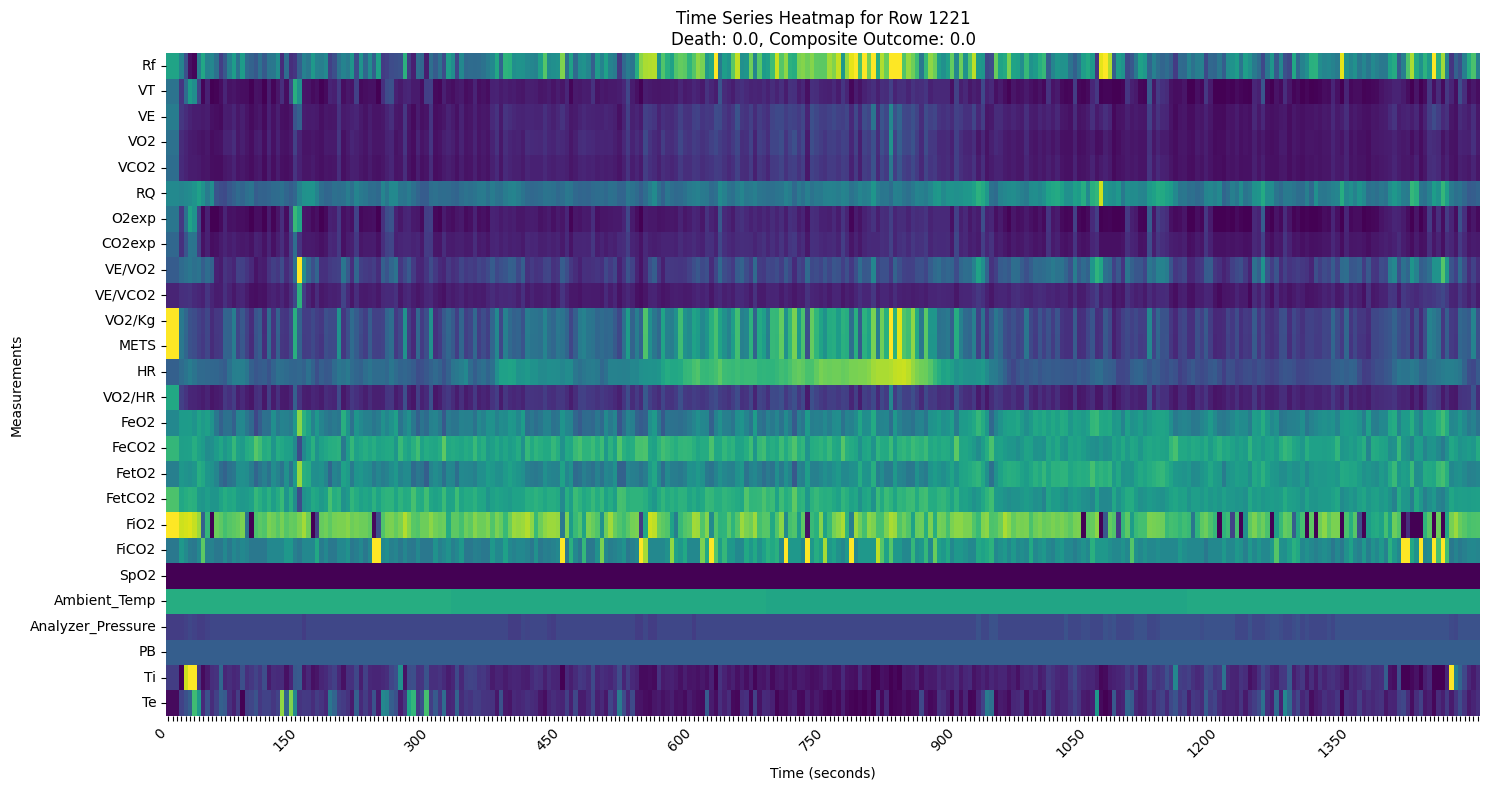

In [35]:
import seaborn as sns

def get_global_min_max(df, time_series_columns):
    """
    Calculate global min and max values for each time series column
    
    Returns:
    --------
    dict: Dictionary with column names as keys and (min, max) tuples as values
    """
    global_ranges = {}
    
    for col in time_series_columns:
        if col == 'Time':
            continue
            
        # Concatenate all non-empty arrays for this column
        all_values = np.concatenate([
            arr for arr in df[col].values 
            if isinstance(arr, np.ndarray) and arr.size > 0
        ])
        
        global_ranges[col] = (np.nanmin(all_values), np.nanmax(all_values))
    
    return global_ranges

def get_global_ranges_robust(df, time_series_columns, lower_percentile=1, upper_percentile=99):
    """
    Calculate global ranges using percentiles to remove outliers
    """
    global_ranges = {}
    
    for col in time_series_columns:
        if col == 'Time':
            continue
            
        # Concatenate all non-empty arrays
        all_values = np.concatenate([
            arr for arr in df[col].values 
            if isinstance(arr, np.ndarray) and arr.size > 0
        ])
        
        # Use percentiles instead of min/max
        min_val = np.nanpercentile(all_values, lower_percentile)
        max_val = np.nanpercentile(all_values, upper_percentile)
        global_ranges[col] = (min_val, max_val)
    
    return global_ranges

def normalize_time_series_data(df, time_series_columns, global_ranges):
    """
    Create a new dataframe with globally normalized time series data
    """
    df_normalized = df.copy()
    
    for col in time_series_columns:
        if col == 'Time':
            continue
            
        min_val, max_val = global_ranges[col]
        df_normalized[col] = df_normalized[col].apply(
            lambda x: np.clip((x - min_val) / (max_val - min_val), 0, 1)  # Added clip here
            if isinstance(x, np.ndarray) and x.size > 0 
            else x
        )
    
    return df_normalized

def plot_normalized_heatmap(df_normalized, row_idx, time_series_columns, figsize=(15, 8), 
                          show_labels=True, show_colorbar=True, filepath=None):
    """
    Plot heatmap using pre-normalized data
    """
    row_data = df_normalized.iloc[row_idx]
    matrix, valid_columns = create_time_series_matrix(row_data, time_series_columns)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create time labels
    time_points = row_data['Time']
    step = len(time_points) // 10
    time_labels = [f'{t:.0f}' if i % step == 0 else '' for i, t in enumerate(time_points)]
    
    # Create mask for NaN values
    mask = np.isnan(matrix)
    
    # Create heatmap with explicit vmin and vmax
    sns.heatmap(matrix.T,
                mask=mask.T,
                xticklabels=time_labels if show_labels else False,
                yticklabels=valid_columns if show_labels else False,
                cmap='viridis',
                vmin=0,    # Added explicit vmin
                vmax=1,    # Added explicit vmax
                cbar=show_colorbar)
    
    if show_labels:
        plt.title(f'Time Series Heatmap for Row {row_idx}\n'
                  f'Death: {row_data["Death"]}, Composite Outcome: {row_data["composite_outcome"]}')
        plt.ylabel('Measurements')
        plt.xlabel('Time (seconds)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    else:
        plt.xticks([])
        plt.yticks([])
        plt.title('')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0 if not show_labels else None, dpi=300)
    
    plt.show()
    plt.close()

# Usage example:
# First, get global min/max values
global_ranges = get_global_ranges_robust(df_interpolated, filtered_time_series_columns)

# Create normalized dataframe
df_normalized = normalize_time_series_data(df_interpolated, filtered_time_series_columns, global_ranges)

# Plot using normalized data
plot_normalized_heatmap(df_normalized, 1221, filtered_time_series_columns, 
                       show_labels=True, show_colorbar=False,
                       filepath='heatmap_globally_normalized.png')

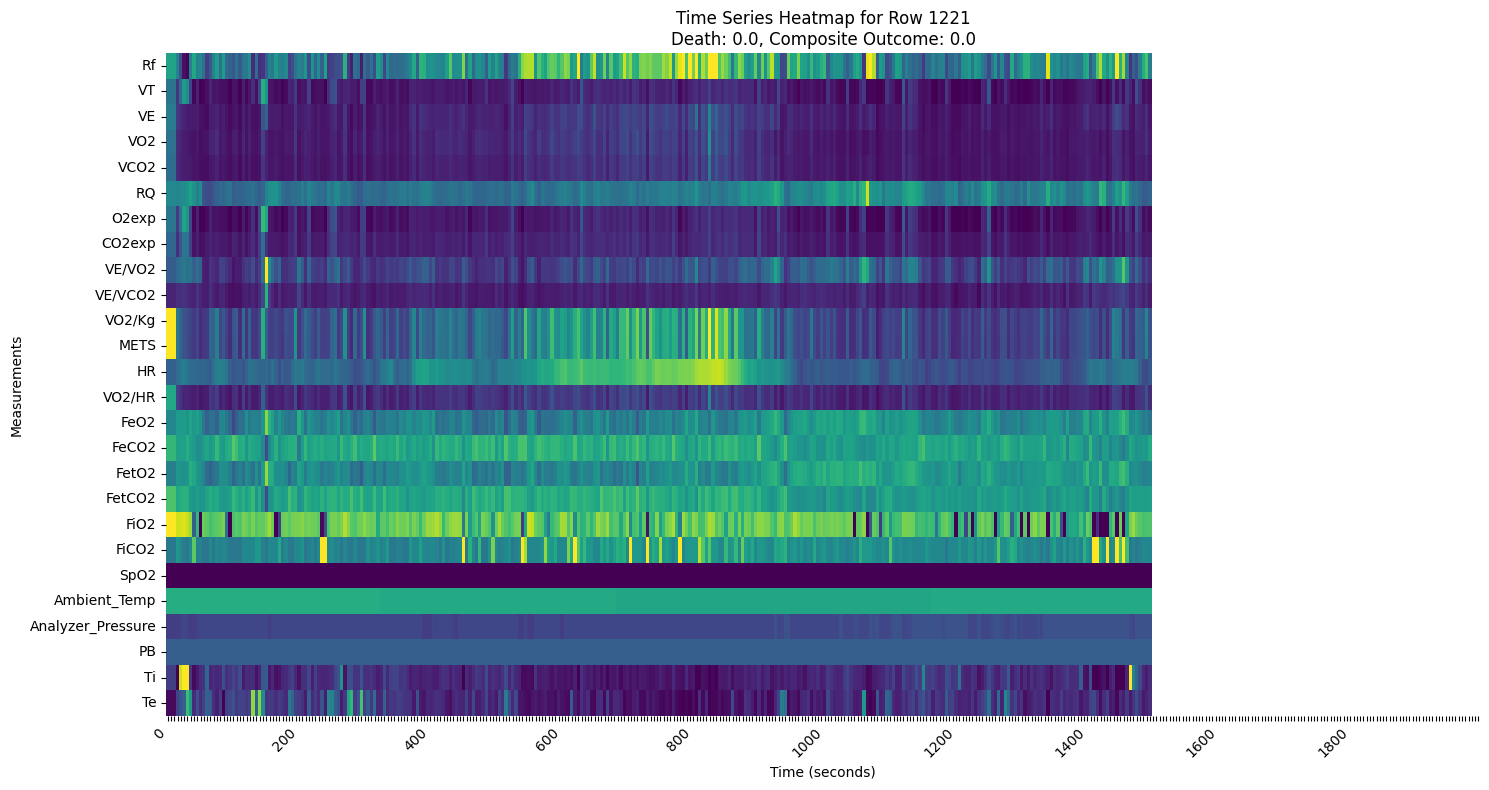

In [51]:
def get_global_max_length(df, time_series_columns):
    """Get the maximum length of any time series in the dataset"""
    max_length = 0
    for _, row in df.iterrows():
        if isinstance(row['Time'], np.ndarray) and row['Time'].size > 0:
            max_length = max(max_length, len(row['Time']))
    return max_length

def pad_time_series(df, time_series_columns, max_length):
    """
    Pad or truncate all time series to the specified length
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input dataframe with time series data
    time_series_columns : list
        List of column names containing time series data
    max_length : int
        Target length for all time series
    """
    df_padded = df.copy()
    
    for col in time_series_columns:
        df_padded[col] = df_padded[col].apply(
            lambda x: (
                # For non-empty arrays:
                np.pad(x[:max_length],  # First truncate, then pad if needed
                      (0, max_length - min(len(x), max_length)),
                      mode='constant',
                      constant_values=np.nan)
                if isinstance(x, np.ndarray) and x.size > 0
                # For empty/missing data:
                else np.full(max_length, np.nan)
            )
        )
    
    return df_padded

# Usage example with manual max_length:
max_length = 2000  # your manually set value
df_padded = pad_time_series(df_interpolated, filtered_time_series_columns, max_length)

def plot_normalized_heatmap(df_normalized, row_idx, time_series_columns, figsize=(15, 8), 
                          show_labels=True, show_colorbar=True, filepath=None):
    """
    Plot heatmap using pre-normalized data with consistent width
    """
    row_data = df_normalized.iloc[row_idx]
    matrix, valid_columns = create_time_series_matrix(row_data, time_series_columns)
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create time labels using global max length
    max_length = matrix.shape[0]
    time_step = 5  # assuming 5-second intervals from interpolation
    time_points = np.arange(0, max_length * time_step, time_step)
    step = len(time_points) // 10
    time_labels = [f'{t:.0f}' if i % step == 0 else '' for i, t in enumerate(time_points)]
    
    # Create mask for NaN values
    mask = np.isnan(matrix)
    
    # Create heatmap with explicit vmin and vmax
    sns.heatmap(matrix.T,
                mask=mask.T,  # Mask will show NaN values as white
                xticklabels=time_labels if show_labels else False,
                yticklabels=valid_columns if show_labels else False,
                cmap='viridis',
                vmin=0,
                vmax=1,
                cbar=show_colorbar)
    
    if show_labels:
        plt.title(f'Time Series Heatmap for Row {row_idx}\n'
                  f'Death: {row_data["Death"]}, Composite Outcome: {row_data["composite_outcome"]}')
        plt.ylabel('Measurements')
        plt.xlabel('Time (seconds)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    else:
        plt.xticks([])
        plt.yticks([])
        plt.title('')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0 if not show_labels else None, dpi=300)
    
    plt.show()
    plt.close()

# Usage:
# First get global ranges and max length
global_ranges = get_global_ranges_robust(df_interpolated, filtered_time_series_columns)
max_length = 400 # 5sec bins #get_global_max_length(df_interpolated, filtered_time_series_columns)

# Pad and normalize the data
df_padded = pad_time_series(df_interpolated, filtered_time_series_columns, max_length)
df_normalized = normalize_time_series_data(df_padded, filtered_time_series_columns, global_ranges)

# Plot
plot_normalized_heatmap(df_normalized, 1221, filtered_time_series_columns, 
                       show_labels=True, show_colorbar=False)

In [47]:
max_length

584

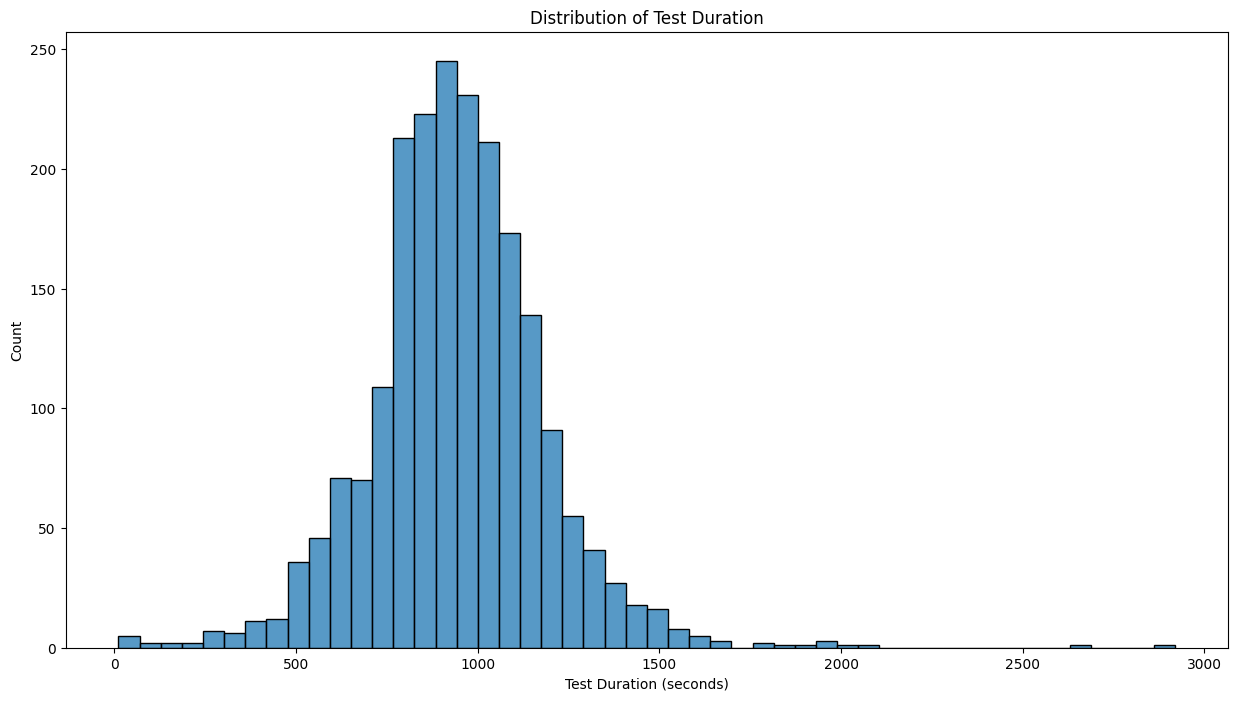

In [38]:
# Calculate and plot the distribution of testDuration
plt.figure(figsize=(15,8))
sns.histplot(data=df_interpolated, x='TestDuration', bins=50)
plt.title('Distribution of Test Duration')
plt.xlabel('Test Duration (seconds)')
plt.ylabel('Count')
plt.show()

In [29]:
df_interpolated["dur"]

{'Rf': (5.600590909090909, 54.55),
 'VT': (0.22865991600981017, 3.4967022077572945),
 'VE': (1.7314902320561256, 118.4327),
 'VO2': (20.030101472184935, 3697.9402665149983),
 'VCO2': (0.7983230265263159, 3953.1594930199963),
 'RQ': (0.3371246753246754, 1.7672678571428488),
 'O2exp': (42.86700021558556, 593.8808025580618),
 'CO2exp': (0.5056801087509765, 153.58079536019582),
 'VE/VO2': (16.7, 78.96324142156851),
 'VE/VCO2': (21.799999999999997, 147.80645833331073),
 'VO2/Kg': (0.25580359477124204, 46.46174999999989),
 'METS': (0.08956068722236749, 13.3),
 'HR': (54.36994444444445, 182.0),
 'VO2/HR': (0.18885518102372034, 24.5),
 'FeO2': (14.8, 20.75),
 'FeCO2': (0.08472222222222223, 5.21),
 'FetO2': (12.755090909090908, 20.565865883681536),
 'FetCO2': (0.10722336010709506, 6.79),
 'FiO2': (20.53, 20.93),
 'FiCO2': (0.03, 0.18),
 'SpO2': (0.0, 99.0),
 'Ambient_Temp': (19.9, 26.7),
 'Analyzer_Pressure': (627.0, 655.0),
 'PB': (754.0, 771.0),
 'Ti': (0.41, 4.320595394736843),
 'Te': (0.5, 

In [33]:
df_normalized.iloc[1222]["FiO2"]

array([0.8       , 0.78333333, 0.875     , 0.875     , 0.825     ,
       0.825     , 0.8125    , 0.8       , 0.875     , 0.775     ,
       0.775     , 0.7875    , 0.81875   , 0.74166667, 0.79375   ,
       0.8       , 0.775     , 0.79375   , 0.75833333, 0.79      ,
       0.775     , 0.78333333, 0.8       , 0.775     , 0.8       ,
       0.53333333, 0.775     , 0.775     , 0.74166667, 0.9       ,
       0.75      , 0.8       , 0.79166667, 0.79642857, 0.80833333,
       0.79375   , 0.8       , 0.825     , 0.8       , 0.825     ,
       0.86666667, 0.75      , 0.8125    , 0.725     , 0.8       ,
       0.83125   , 0.825     , 0.80833333, 0.80625   , 0.8       ,
       0.8625    , 0.85833333, 0.9       , 0.875     , 0.86666667,
       0.86875   , 0.875     , 0.83333333, 0.82857143, 0.84642857,
       0.85      , 0.93333333, 0.85833333, 0.8625    , 0.875     ,
       0.8875    , 0.83333333, 0.83333333, 0.75833333, 0.775     ,
       0.75833333, 0.8       , 0.7375    , 0.795     , 0.725  

In [49]:
df_normalized.iloc[1221]["TestDuration"]

1500.0